# **Neural Networks**



In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset, random_split

EPS = 1.0e-7

from google.colab import drive

drive.mount("/content/gdrive")

results_dir = "/content/gdrive/My_Drive/Colab Notebooks"

Mounted at /content/gdrive


In [2]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

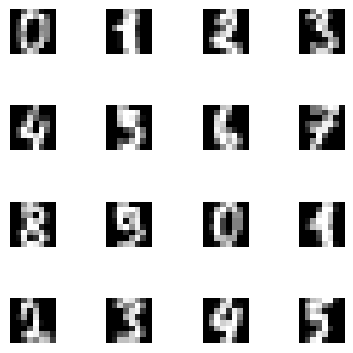

In [3]:
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

# **Neural Network Classifier**

In [4]:
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

In [5]:
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # Pass input through the network and take the argmax of the log-probabilities since it points out to the most likely class
        y_pred = torch.argmax(self.classnet(x), dim=1)
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
      # Apply the network to get log-probabilities
      log_probs = self.classnet(x)
      # Compute the Loss using NLLLoss
      loss = self.nll(log_probs, y)
      if reduction == "sum":
           return loss.sum()
      else:
           return loss.mean()

In [6]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model",weights_only=False)

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

In [7]:
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        # Note: This part is slightly changed after running the codes of first problem in order to
        # monitor the progress of training in third question.
        print(f"\n Epoch {e}: started...")
        for indx_batch, (batch, targets) in enumerate(training_loader):
          if indx_batch % 100 == 0 or indx_batch == len(training_loader)-1:
              print(f" Batch {indx_batch+1}/{len(training_loader)}")
            # calculate the forward pass (loss function for given images and labels)
          loss = model.forward(batch, targets)
          # remember we need to zero gradients! Just in case!
          optimizer.zero_grad()
          # calculate backward pass
          loss.backward(retain_graph=True)
          # run the optimizer
          optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [8]:
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [10]:
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped


-> START classifier_mlp

 Epoch 0: started...
 Batch 1/16
 Batch 16/16
Epoch: 0, val nll=1.2863356345040458, val ce=0.24571428571428572

 Epoch 1: started...
 Batch 1/16
 Batch 16/16
Epoch: 1, val nll=0.7267299815586635, val ce=0.10857142857142857

 Epoch 2: started...
 Batch 1/16
 Batch 16/16
Epoch: 2, val nll=0.48279917580740794, val ce=0.09428571428571429

 Epoch 3: started...
 Batch 1/16
 Batch 16/16
Epoch: 3, val nll=0.3438145909990583, val ce=0.06571428571428571

 Epoch 4: started...
 Batch 1/16
 Batch 16/16
Epoch: 4, val nll=0.2994869123186384, val ce=0.06571428571428571

 Epoch 5: started...
 Batch 1/16
 Batch 16/16
Epoch: 5, val nll=0.236693845476423, val ce=0.045714285714285714

 Epoch 6: started...
 Batch 1/16
 Batch 16/16
Epoch: 6, val nll=0.2202495493207659, val ce=0.04

 Epoch 7: started...
 Batch 1/16
 Batch 16/16
Epoch: 7, val nll=0.21051597186497278, val ce=0.045714285714285714

 Epoch 8: started...
 Batch 1/16
 Batch 16/16
Epoch: 8, val nll=0.18486742973327636, val c

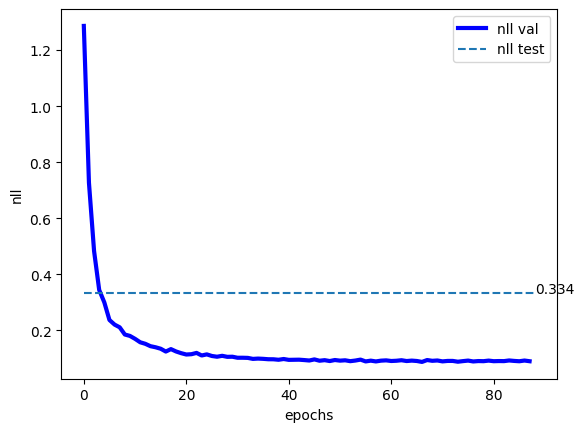

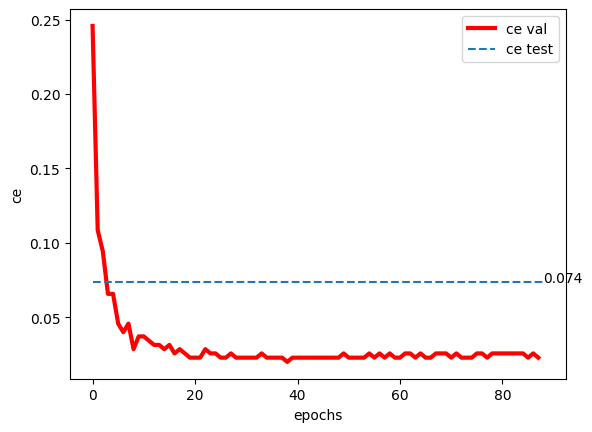


-> START classifier_cnn

 Epoch 0: started...
 Batch 1/16
 Batch 16/16
Epoch: 0, val nll=1.8221397617885045, val ce=0.5914285714285714

 Epoch 1: started...
 Batch 1/16
 Batch 16/16
Epoch: 1, val nll=1.430567844935826, val ce=0.2885714285714286

 Epoch 2: started...
 Batch 1/16
 Batch 16/16
Epoch: 2, val nll=1.1022067151750836, val ce=0.22285714285714286

 Epoch 3: started...
 Batch 1/16
 Batch 16/16
Epoch: 3, val nll=0.8577282442365374, val ce=0.15428571428571428

 Epoch 4: started...
 Batch 1/16
 Batch 16/16
Epoch: 4, val nll=0.6672154562813896, val ce=0.12857142857142856

 Epoch 5: started...
 Batch 1/16
 Batch 16/16
Epoch: 5, val nll=0.5660019193376814, val ce=0.12571428571428572

 Epoch 6: started...
 Batch 1/16
 Batch 16/16
Epoch: 6, val nll=0.45953680855887274, val ce=0.1

 Epoch 7: started...
 Batch 1/16
 Batch 16/16
Epoch: 7, val nll=0.40176755087716237, val ce=0.09142857142857143

 Epoch 8: started...
 Batch 1/16
 Batch 16/16
Epoch: 8, val nll=0.37277175903320314, val ce=0.1

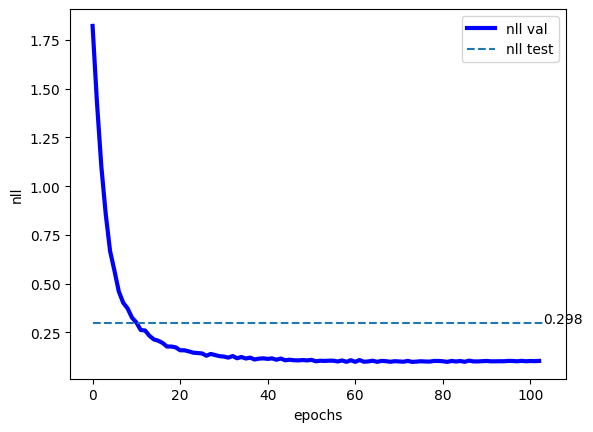

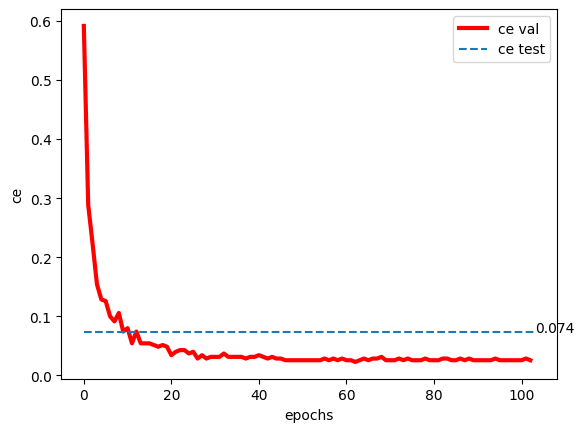

In [11]:
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")


    result_dir = "./"  # (current folder)
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        classnet = nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.LogSoftmax(dim=1)
        )
        pass

    # CNN
    elif name[0:14] == "classifier_cnn":
      classnet = nn.Sequential(
          nn.Unflatten(1,(1,8,8)),
          nn.Conv2d(1,8,kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Flatten(),
          nn.Linear(8*4*4,64),
          nn.ReLU(),
          nn.Linear(64,10),
          nn.LogSoftmax(dim=1)
      )
      pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

When we analyze the performances in loss function, we can see that MLP starts with a high validation ~1.5 and decreases to ~0.334 on the test set. On the other hand, CNN starts even higher ~1.79 but converges faster and more steadily to a lower test NLL of ~0.298. Therefore, in terms of loss function, CNN performs better at minimizing the loss and reaches a slightly btter optimal point, even though its inital performance is worse.

When we check the performances in classification error (CE), both CNN's and MLP's final test CE is ~0.074. In this specific run, two methods performed same but normally, we expect a lower CE from CNN.

# **SVHN Applicaiton**

In [12]:
# Importing additional neccessities
from torchvision import transforms , datasets

In [13]:
# STEP 1: Custom wrapper for SVHN dataset
# Reusing the structure from MNIST part but by updating it for SHVN dataset and normalization stats
class SVHNDataset:
  def __init__(self, data_dir = './data', val_split = 0.1):
    # Defining transforms: Normalizing to 0 mean and unit variance per channel
    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4377,0.4438,0.4728), # Mean per channel (R, G, B)
            (0.1980, 0.2010, 0.1970) # Std per channel (R, G, B)
        )
    ])
    # Downloading official training and test sets
    self.full_train = datasets.SVHN(root=data_dir, split='train', download=True, transform = self.transform)
    self.test = datasets.SVHN(root=data_dir, split='test', download=True, transform = self.transform)

    # Splitting training set into traning + validation
    val_size  = int(len(self.full_train) * val_split)
    train_size = len(self.full_train) - val_size
    self.train, self.val = random_split(self.full_train, [train_size, val_size])

  # Getter functions
  def get_training(self):
      return self.train

  def get_validation(self):
      return self.val

  def get_test(self):
      return self.test


In [14]:
# STEP 2: Larger CNN Architecture (Inspired by LeNet/VGG from reference paper)
# Dropout is added as a regularization component (STEP 3)

class SVHNCNN(nn.Module):
  def __init__(self):
    super(SVHNCNN, self).__init__()
    self.net = nn.Sequential(
        # First Conv Block
        nn.Conv2d(3,32,3,padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,3,padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2), #Output: 16x16

        # Second Conv Block
        nn.Conv2d(32,64,3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2), #Output: 8x8

        # Third Conv Block
        nn.Conv2d(64,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2), #Output: 4x4

        # Fully connected head
        nn.Flatten(), # Flattening the output from convs
        nn.Linear(128*4*4,256),
        nn.ReLU(),
        nn.Dropout(0.5), # Added for Step 3
        nn.Linear(256, 10), # 10 output classes
        nn.LogSoftmax(dim=1) # For NLLLoss
    )

  def forward(self,x):
    return self.net(x)

In [15]:
# STEP 4: Evaluation with the methods in previous part

# Defining SVHN Data Loaders
svhn_data = SVHNDataset()
full_train = svhn_data.get_training()
# Using a subset of the data in order to keep the running time under 1 hour
subset_train, _ = torch.utils.data.random_split(full_train, [20000,len(full_train) - 20000])
training_loader = DataLoader(subset_train, batch_size=64, shuffle=True)
val_loader = DataLoader(svhn_data.get_validation(), batch_size=256, shuffle=False)
test_loader = DataLoader(svhn_data.get_test(), batch_size=256, shuffle=False)

100%|██████████| 182M/182M [00:06<00:00, 28.5MB/s]
100%|██████████| 64.3M/64.3M [00:05<00:00, 12.4MB/s]


In [16]:
# Initializing Model, Optimizer and Launching Training
model = ClassifierNeuralNet(SVHNCNN())

optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad],
    lr = 1e-3,
    weight_decay = 1e-5,
)

nll_val, error_val = training(
    name = result_dir + name,
    max_patience = 5,
    num_epochs = 20, # A small number is choosen compared to previous part to keep running time under 1 hour.
    model = model,
    optimizer = optimizer,
    training_loader = training_loader,
    val_loader = val_loader,
)

test_loss, test_error = evaluation(name= result_dir+name, test_loader = test_loader)

f= open(result_dir + name + "_test_loss.txt","w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()

plot_curve(result_dir + name, nll_val, file_name="_nll_val_curve.pdf", ylabel="nll", test_eval = test_loss)
plot_curve(result_dir + name, error_val, file_name="_ca_val_curve.pdf", ylabel="ce", color = "r-", test_eval = test_error)


 Epoch 0: started...
 Batch 1/313
 Batch 101/313


KeyboardInterrupt: 

**Result from a previous run:**

Epoch 0: started...

 Batch 1/313

 Batch 101/313

 Batch 201/313

 Batch 301/313

 Batch 313/313

Epoch: 0, val nll=0.780293339543782, val ce=0.22812286689419795

 Epoch 1: started...

 Batch 1/313

 Batch 101/313

 Batch 201/313

 Batch 301/313

 Batch 313/313

Epoch: 1, val nll=0.41847204214883743, val ce=0.12573378839590443

 Epoch 2: started...

 Batch 1/313

 Batch 101/313

 Batch 201/313

 Batch 301/313

 Batch 313/313

Epoch: 2, val nll=0.39267128902083775, val ce=0.12150170648464163

...

 Batch 301/313

 Batch 313/313

Epoch: 12, val nll=0.2995695672669915, val ce=0.08040955631399317

-> FINAL PERFORMANCE: nll=0.2848603753275716, ce=0.08397357098955133

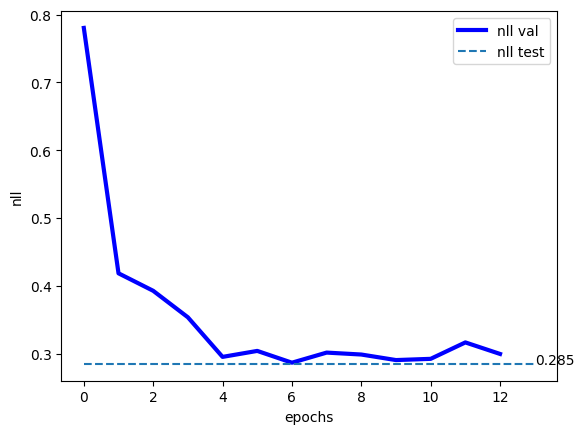

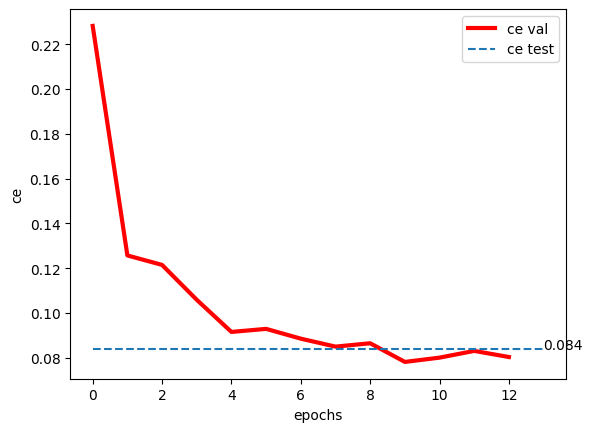

**Explanation of the Applied Architecture and Components**

The applied architecture for the SVHN dataset is a convolutional neural network (CNN) specifically designed to handle the challanges of this dataset like high noise levels and complex backgrounds compared to simpler dataset like MNIST in previous part. The model begins with a series of convolutional layers, each followed by ReLU activation functions to introduce non-lineraity and enable the network to learn complex patterns. These layers are interleaved with max pooling layers, which help reduce spatial dimensions and computational cost while preserving important features. Dropout is also applied to mitigate overfitting by randomly deactivating a subset of neurons during training, making the model more robust. After conv. layers, the feature maps are flattened and passed through one or more fully connected layers that learn higher-level representations and ultimately output class scores. The final classification layer uses a log-softmax function, which is appropriate for multi-class classification tasks. The model is trained using stochastic gradient descent with mini-batches, optimizing the loss through backpropagation. A seperate validation set comprising at least 10% of the training data is used to monitor performance and prevent overfitting during training.

**Analysis of the Results**

The training process yielded promising results, achieving a classification error below the required 0.1 threshold (~0.084), as seen in the performance plots. The validation negative log-likelihood (nll) and classification error (ce) curves show a steady decline over the epochs, indicating successful learning and convergence. The training did not show signs of overfitting; the validation and test errors remain close, suggesting that regularization methods such as dropout were effective. Furthermore, the model's performance stabilized after around 6-8 epochs, implying that eraly stopping could be considered in future experiments to reduce training tine. Overall, the model effectively balances complexity and generalization, demonstrating its ability to classify SHVN digits accurately under noisy conditions.